# Research Agent with MCP

*The goal of research is to gather the context requested by the research brief.*

## Model Context Protocol 

We showed how to use native search tools from LLM providers. We also defined and used search APIs as external tools. The [Model Context Protocol (MCP)](https://modelcontextprotocol.io/specification/2025-06-18/architecture) provides another  way to access tools. 

### MCP Python SDK 

The [MCP Python SDK](https://github.com/modelcontextprotocol/python-sdk) provides a standardized way to build servers and clients for LLM interactions. It allows you to expose data, functionality, and interaction patterns to AI applications.

**Key Components:**
- **FastMCP**: Primary server class for creating MCP servers
- **Resources**: Endpoints for loading information into LLM context  
- **Tools**: Functions that enable LLMs to take actions
- **Prompts**: Reusable templates for structured LLM interactions
- **Context**: Provides access to MCP capabilities during tool/resource execution

**Server vs Client Architecture:**
- **Server-side**: Create endpoints using decorators like `@mcp.tool()`, `@mcp.resource()`
- **Client-side**: Connect to MCP servers and interact with exposed resources and tools

**Key Features:**
- Structured output support
- Type-safe context management
- Progress reporting and image handling
- Lifecycle management for server dependencies
- Flexible interaction patterns

**When to Use Direct MCP SDK:**
- You need **detailed error debugging**
- You want **explicit control** over connection lifecycle
- You're **developing/testing** new server configurations
- You need **custom session management**

## LangChain MCP Adapters 

The [LangChain MCP Adapters](https://github.com/langchain-ai/langchain-mcp-adapters) provide a seamless bridge between the Model Context Protocol (MCP) and LangChain/LangGraph ecosystems. This lightweight library enables compatibility between MCP servers and our LangGraph agent.

**What It Provides:**
- **🛠️ Convert MCP tools** into LangChain tools that can be used with LangGraph agents
- **📦 Multi-server client** implementation to connect to multiple MCP servers simultaneously
- **🔄 Bidirectional conversion** between MCP and LangChain tool formats
- **🌐 Transport support** for stdio, streamable-http, and custom authentication

**Key Components:**
- **`MultiServerMCPClient`**: High-level wrapper for connecting to multiple MCP servers
- **`to_fastmcp()`**: Converts LangChain tools to MCP-compatible tools
- **Transport mechanisms**: Support for stdio, streamable-http with custom headers

**Integration Benefits:**
1. **Unified Interface**: Use MCP servers just like any other LangChain tool
2. **Configuration Management**: Centralized configuration for multiple servers
3. **Type Safety**: Proper type annotations for tool parameters
4. **Tool Metadata**: Rich metadata about tool capabilities and parameters
5. **Seamless Integration**: Works with existing LangChain workflows

**When to Use LangChain MCP Adapters:**
- You want **simple, clean code**
- You need to manage **multiple MCP servers** 
- You prefer **high-level abstractions**
- Your server configurations are **stable and tested**
- You're building **production LangChain applications**

## MCP Server Options

Now, let's explore two popular MCP servers that demonstrate different capabilities:

### 🎭 Playwright MCP Server

The [Playwright MCP Server](https://github.com/microsoft/playwright-mcp) enables AI models to interact with web pages through browser automation. It provides a lightweight, deterministic approach to web interaction.

**What It Provides:**
- **Browser automation** using accessibility tree data (default)
- **Visual interactions** with screenshot-based mode  
- **Multi-browser support** (Chrome, Firefox, WebKit)
- **Cross-platform compatibility** with isolated browser profiles

**Available Tools:**
- **Navigation**: Navigate URLs, go back/forward, take screenshots, save PDFs
- **Interaction**: Click, drag, hover, type text, select options, press keys
- **Dialog Handling**: Handle browser dialogs and popups
- **Utilities**: Install browsers, resize windows, capture network requests, console messages

**Installation:**
```bash
npx @playwright/mcp@latest
```

**Configuration Example:**
```python
mcp_config = {
    "playwright": {
        "command": "npx",
        "args": ["@playwright/mcp"],
        "transport": "stdio"
    }
}
```

**Key Features:**
- **Fast & Lightweight**: Uses accessibility snapshots instead of heavy visual processing
- **LLM-Friendly**: Structured data format optimized for AI interaction
- **Deterministic**: Consistent behavior across runs
- **Configurable**: Supports both snapshot and vision modes

**Best Use Cases:**
- Web scraping and data extraction
- Automated testing and QA
- Research and information gathering
- Dynamic web content interaction

### 📁 Filesystem MCP Server

The [Filesystem MCP Server](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem) provides secure, controlled access to local file systems with granular permission management.

**What It Provides:**
- **File operations** with strict access control
- **Directory management** with dynamic permissions
- **Search capabilities** across allowed directories
- **Metadata access** for files and directories

**Available Tools:**
- **File Operations**: `read_file`, `write_file`, `edit_file`, `read_multiple_files`
- **Directory Management**: `create_directory`, `list_directory`, `move_file`
- **Search & Discovery**: `search_files`, `get_file_info`, `list_allowed_directories`

**Installation:**
```bash
npm install -g @modelcontextprotocol/server-filesystem
```

**Configuration Example:**
```python
mcp_config = {
    "filesystem": {
        "command": "npx",
        "args": [
            "-y",
            "@modelcontextprotocol/server-filesystem", 
            "/path/to/allowed/directory"
        ],
        "transport": "stdio"
    }
}
```

**Security Features:**
- **Directory Access Control**: Only operates within specified directories
- **Permission Management**: Read-only or read-write access per directory
- **Dynamic Configuration**: Can update allowed directories at runtime
- **Safe Operations**: Prevents access outside configured boundaries

**Best Use Cases:**
- Document processing and analysis
- Code repository management
- Research document organization
- Controlled file system automation

### 🤔 Choosing the Right Server

| Use Case | Playwright MCP | Filesystem MCP |
|----------|----------------|----------------|
| **Web Research** | ✅ Excellent | ❌ Not applicable |
| **Document Analysis** | ❌ Not applicable | ✅ Perfect |
| **Data Extraction** | ✅ Web sources | ✅ Local files |
| **Content Creation** | ⚠️ Limited | ✅ Full editing |
| **Security Concerns** | ⚠️ Web access | ✅ Controlled local access |
| **Setup Complexity** | 🟢 Simple | 🟢 Simple |

### 🤖 Agent

Let's create an agent using LangGraph [create_react_agent pre-built](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent).

This just wraps what we showed in 2_research_agent_mcp.ipynb into a single function call.

In [28]:
# Simple MCP Example
import os
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model

# First, let's install the MCP filesystem server if not already installed
# Run this in a separate cell: !npm install -g @modelcontextprotocol/server-filesystem

# Get the absolute path to our sample research docs
sample_docs_path = os.path.abspath("./files/")
print(f"Sample docs path: {sample_docs_path}")

# Check if the directory exists
if os.path.exists(sample_docs_path):
    print(f"Directory exists with files: {os.listdir(sample_docs_path)}")
else:
    print("Directory does not exist!")

# MCP Client configuration - filesystem server for local document access
mcp_config = {
    "filesystem": {
        "command": "npx",
        "args": [
            "-y",  # Auto-install if needed
            "@modelcontextprotocol/server-filesystem",
            sample_docs_path
        ],
        "transport": "stdio"
    }
}

print("Creating MCP client...")
client = MultiServerMCPClient(mcp_config)
print("MCP client created successfully!")

# Test getting tools
print("Getting tools...")
tools = await client.get_tools()
print(f"Successfully got {len(tools)} tools:")
for tool in tools:
    print(f"  - {tool.name}: {tool.description}")

# Improved system prompt with security-first approach
system_prompt = """You are a research assistant with access to local file system tools through MCP (Model Context Protocol). Your role is to help users conduct thorough research by systematically accessing and analyzing local documents.

CRITICAL SECURITY STEP:
🔒 ALWAYS start by calling list_allowed_directories to check what directories you can access. This is a security requirement that prevents access errors.

AVAILABLE TOOLS:
You have access to filesystem tools that can:
- list_allowed_directories: Returns directories you can access (CALL THIS FIRST!)
- list_directory: List files and directories in the research documents folder
- read_file: Read the complete contents of specific files
- read_multiple_files: Read multiple files simultaneously (more efficient)
- search_files: Search for files containing specific content
- get_file_info: Get metadata about files (size, modification date, etc.)

SECURE RESEARCH METHODOLOGY:
1. **FIRST - Check permissions**: Use list_allowed_directories to see what you can access
2. **Then explore**: Use list_directory to see available files in allowed directories
3. **Read strategically**: Only read files that are relevant to the user's request
4. **Read each file ONCE**: Don't repeatedly read the same file - remember the content
5. **Use efficient tools**: Use read_multiple_files when you need multiple files
6. **Be targeted**: Focus on files that match the user's specific needs

AVAILABLE FILES (typically):
Based on the expected directory structure, you should find:
- coffee_shops_sf.md: Contains information about San Francisco coffee shops
- reasoning.md: Contains reasoning or methodology content

RESPONSE OPTIMIZATION:
- ALWAYS start with list_allowed_directories
- Then use list_directory to confirm available files
- Clearly identify which files are relevant to the user's request
- Read only the necessary files for the specific question
- Avoid reading all files if only one is needed
- Cite file names when referencing information
- Provide focused answers based on the relevant content

EXAMPLE WORKFLOW:
1. Call list_allowed_directories (security check)
2. Call list_directory on allowed directory
3. For coffee shop questions → Read coffee_shops_sf.md
4. For methodology questions → Read reasoning.md
5. For general questions → Determine which files are most relevant first

Remember: Security first - always check allowed directories before attempting any file operations!"""

# Create agent with improved system prompt
print("Creating agent...")
model = init_chat_model("anthropic:claude-sonnet-4-20250514")
agent = create_react_agent(model, tools)
print("Agent created successfully!")

# Enhanced prompt that guides the LLM to use MCP tools effectively
research_prompt = """
I need comprehensive information about coffee shops in San Francisco. 

 **Provide a comprehensive summary**: Based on the files you've read, give me a detailed overview of:
   - Popular coffee shops and their specialties
   - Local coffee culture and trends  
   - Best neighborhoods for coffee enthusiasts
   - Unique or notable coffee experiences in SF
"""

Sample docs path: /Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files
Directory exists with files: ['reasoning.md', 'coffee_shops_sf.md']
Creating MCP client...
MCP client created successfully!
Getting tools...
Successfully got 12 tools:
  - read_file: Read the complete contents of a file from the file system. Handles various text encodings and provides detailed error messages if the file cannot be read. Use this tool when you need to examine the contents of a single file. Use the 'head' parameter to read only the first N lines of a file, or the 'tail' parameter to read only the last N lines of a file. Only works within allowed directories.
  - read_multiple_files: Read the contents of multiple files simultaneously. This is more efficient than reading files one by one when you need to analyze or compare multiple files. Each file's content is returned with its path as a reference. Failed reads for individual files won't stop the entire operation. Only works within allowed

### ⚠️ Why Async is Required for MCP Tools

When using MCP tools with LangChain, you MUST use async methods.

If you try to use sync methods, you'll get this error:
```
╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: NotImplementedError('StructuredTool does not support sync invocation.')                                  │
│  Please fix your mistakes.     
```

#### Why async is required:

1. **MCP Protocol Design**: The Model Context Protocol is inherently asynchronous
    - Server communication uses async JSON-RPC over stdio/http
    - Tool invocations involve network/IPC calls that can be slow
    - Async enables non-blocking, concurrent operations

2. **LangChain MCP Adapters**: The adapters are designed for async-only operation
    - Tools are wrapped as async StructuredTools
    - Sync invocation is intentionally not implemented
    - This ensures consistent async behavior across all MCP tools

3. **Performance Benefits**: Async enables:
    - Concurrent tool execution
    - Non-blocking server communication
    - Better resource utilization
    - Responsive applications

4. **Technical Architecture**: 
    - MCP servers run as subprocesses
    - Communication happens over pipes (stdin/stdout)
    - These I/O operations are naturally async
    - Blocking sync calls would freeze the entire process

#### Use async methods with MCP tools
* ✅ Correct: agent.ainvoke() - async
* ❌ Incorrect: agent.invoke() - sync (will fail)

In [23]:
# Test with async invocation
result = await agent.ainvoke({
    "messages": [{"role": "system", "content": system_prompt}, {"role": "user", "content": research_prompt}]
})

from utils import format_messages
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 📝 System ───────────────────────────────────────────────────╮
│ You are a research assistant with access to local file system tools through MCP (Model Context Protocol). Your  │
│ role is to help users conduct thorough research by systematically accessing and analyzing local documents.      │
│                                                                                                                 │
│ AVAILABLE FILES:                                                                                                │
│ Based on the directory listing, you have access to these files:                                                 │
│ - coffee_shops_sf.md: Contains information about San Francisco coffee shops                                     │
│ - reasoning.md: Contains reasoning or methodology content                                                       │
│                                                                                                                 │
│ AVAILABLE TOOLS:                                                                                                │
│ You have access to filesystem tools that can:                                                                   │
│ - list_directory: List files and directories in the research documents folder                                   │
│ - read_file: Read the complete contents of specific files                                                       │
│ - read_multiple_files: Read multiple files simultaneously (more efficient)                                      │
│ - search_files: Search for files containing specific content                                                    │
│ - get_file_info: Get metadata about files (size, modification date, etc.)                                       │
│                                                                                                                 │
│ EFFICIENT RESEARCH METHODOLOGY:                                                                                 │
│ 1. **Start with exploration**: Use list_directory to confirm available files                                    │
│ 2. **Read strategically**: Only read files that are relevant to the user's request                              │
│ 3. **Read each file ONCE**: Don't repeatedly read the same file - remember the content                          │
│ 4. **Use efficient tools**: Use read_multiple_files when you need multiple files                                │
│ 5. **Be targeted**: Focus on files that match the user's specific needs                                         │
│                                                                                                                 │
│ RESPONSE OPTIMIZATION:                                                                                          │
│ - Clearly identify which files are relevant to the user's request                                               │
│ - Read only the necessary files for the specific question                                                       │
│ - Avoid reading all files if only one is needed                                                                 │
│ - Cite file names when referencing information                                                                  │
│ - Provide focused answers based on the relevant content                                                         │
│                                                                                                                 │
│ EXAMPLE APPROACH:                                                                                               │
│ For coffee shop questions → Read coffee_shops_sf.md                                                             │
│ For methodology questions → Read reasoning.md                                                                   │
│ For general questions → Determine which files are most 

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I need comprehensive information about coffee shops in San Francisco.                                           │
│                                                                                                                 │
│  **Provide a comprehensive summary**: Based on the files you've read, give me a detailed overview of:           │
│    - Popular coffee shops and their specialties                                                                 │
│    - Local coffee culture and trends                                                                            │
│    - Best neighborhoods for coffee enthusiasts                                                                  │
│    - Unique or notable coffee experiences in SF                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get comprehensive information about coffee shops in San Francisco. Let me first check what files  │
│ are available and then read the relevant content.                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "."                                                                                                   │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "."                                                                                                   │
│ }                                                                                                               │
│    ID: toolu_01GF9VHMphCjyMNL2Zwy38if                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error: ToolException('Error: Access denied - path outside allowed directories:                                  │
│ /Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks not in                                             │
│ /Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files')                                            │
│  Please fix your mistakes.                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me check the allowed directories first:                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: list_allowed_directories                                                                          │
│    Args: {}                                                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: list_allowed_directories                                                                          │
│    Args: {}                                                                                                     │
│    ID: toolu_01BPYs1tspZPruw6Kc7o49ma                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Allowed directories:                                                                                            │
│ /Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me check what files are available in the allowed directory:                                             │
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files"                                  │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files"                                  │
│ }                                                                                                               │
│    ID: toolu_01VDhfX2yaqkC57fPRghMPnD                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ [FILE] coffee_shops_sf.md                                                                                       │
│ [FILE] reasoning.md                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! I can see the `coffee_shops_sf.md` file which is exactly what I need for your request. Let me read     │
│ this file to provide you with comprehensive information about San Francisco coffee shops:                       │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files/coffee_shops_sf.md"               │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files/coffee_shops_sf.md"               │
│ }                                                                                                               │
│    ID: toolu_01DTywqEdCJrVuMn7HVWzu6x                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # San Francisco Coffee Shops Research                                                                           │
│                                                                                                                 │
│ ## Top Coffee Shops in San Francisco                                                                            │
│                                                                                                                 │
│ ### Blue Bottle Coffee                                                                                          │
│ - **Founded**: 2002 in Oakland, expanded to SF                                                                  │
│ - **Specialty**: Single-origin coffee, pour-over methods                                                        │
│ - **Notable**: Known for freshly roasted beans, minimalist aesthetic                                            │
│ - **Locations**: Multiple SF locations including Ferry Building                                                 │
│                                                                                                                 │
│ ### Philz Coffee                                                                                                │
│ - **Founded**: 2003 in San Francisco                                                                            │
│ - **Specialty**: Custom blended coffee, personalized service                                                    │
│ - **Notable**: Founded by Phil Jaber, known for unique blends like "Tesora"                                     │
│ - **Locations**: Original location in Mission District, now citywide                                            │
│                                                                                                                 │
│ ### Sightglass Coffee                                                                                           │
│ - **Founded**: 2009                                                                                             │
│ - **Specialty**: Third-wave coffee, roasting transparency                                                       │
│ - **Notable**: Large roastery with viewing windows, industrial aesthetic                                        │
│ - **Location**: SOMA district flagship location                                                                 │
│                                                                                                                 │
│ ### Ritual Coffee Roasters                                                                                      │
│ - **Founded**: 2005                                                                                             │
│ - **Specialty**: Direct trade relationships, seasonal offerings                                                 │
│ - **Notable**: Pioneer in San Francisco's third-wave coffee movement                                            │
│ - **Locations**: Multiple locations including Castro and Mission                                                │
│                                                                                                                 │
│ ### Four Barrel Coffee                                                                                          │
│ - **Founded**: 2008                                                                                             │
│ - **Specialty**: Small-batch roasting, community focus                                                          │
│ - **Notable**: Known for Valencia Street location, local institution                                            │
│ - **Location**: Mission District                                                                                │
╰────────────────────────────────────────────────────────

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the information from the `coffee_shops_sf.md` file, here's a comprehensive overview of San Francisco's │
│ coffee shop scene:                                                                                              │
│                                                                                                                 │
│ ## **Popular Coffee Shops and Their Specialties**                                                               │
│                                                                                                                 │
│ ### **Blue Bottle Coffee**                                                                                      │
│ - **Specialty**: Single-origin coffee and pour-over methods                                                     │
│ - **Notable Features**: Known for freshly roasted beans and minimalist aesthetic                                │
│ - **Founded**: 2002 in Oakland, expanded to SF                                                                  │
│ - **Key Location**: Ferry Building (among multiple SF locations)                                                │
│                                                                                                                 │
│ ### **Philz Coffee**                                                                                            │
│ - **Specialty**: Custom blended coffee with personalized service                                                │
│ - **Notable Features**: Founded by Phil Jaber, famous for unique blends like "Tesora"                           │
│ - **Founded**: 2003 in San Francisco                                                                            │
│ - **Origin**: Started in Mission District, now citywide                                                         │
│                                                                                                                 │
│ ### **Sightglass Coffee**                                                                                       │
│ - **Specialty**: Third-wave coffee with roasting transparency                                                   │
│ - **Notable Features**: Large roastery with viewing windows, industrial aesthetic                               │
│ - **Founded**: 2009                                                                                             │
│ - **Key Location**: SOMA district flagship location                                                             │
│                                                                                                                 │
│ ### **Ritual Coffee Roasters**                                                                                  │
│ - **Specialty**: Direct trade relationships and seasonal offerings                                              │
│ - **Notable Features**: Pioneer in San Francisco's third-wave coffee movement                                   │
│ - **Founded**: 2005                                                                                             │
│ - **Locations**: Multiple locations including Castro and Mission                                                │
│                                                                                                                 │
│ ### **Four Barrel Coffee**                                                                                      │
│ - **Specialty**: Small-batch roasting with community focus                                                      │
│ - **Notable Features**: Local institution known for Valencia Street location                                    │
│ - **Founded**: 2008                                                                                             │
│ - **Location**: Mission District                       

## 🔍 Breaking Down the MCP Workflow: Step by Step

### What Just Happened? Let's Understand Each Component

#### 1. 📋 The `mcp_config` Dictionary
```python
mcp_config = {
    "filesystem": {  # Server name (arbitrary label)
        "command": "npx",  # Command to run
        "args": ["-y", "@modelcontextprotocol/server-filesystem", "/path/to/docs"],
        "transport": "stdio"  # Communication method
    }
}
```

**What it is**: A configuration dictionary that tells the MCP client how to start and connect to MCP servers.

**Key parts**:
- **Server name** (`"filesystem"`): An arbitrary label for this server instance
- **Command** (`"npx"`): The command to execute to start the server
- **Args**: Command-line arguments passed to the server
- **Transport**: How the client communicates with the server (stdio = standard input/output)

#### 2. 🖥️ Is This a Locally Running Process?
**YES!** Here's what happens:

1. **Server Startup**: When you create `MultiServerMCPClient(mcp_config)`, it:
   - Executes `npx @modelcontextprotocol/server-filesystem /path/to/docs`
   - This starts a **subprocess** running the filesystem server
   - The server runs **locally on your machine**

2. **Communication**: The client and server communicate through:
   - **STDIN**: Client sends requests to the server
   - **STDOUT**: Server sends responses back to the client
   - **Structured JSON**: All communication uses the MCP protocol format

3. **Lifecycle**: The server process runs as long as the client is active

#### 3. 🔧 What is the `client`?
```python
client = MultiServerMCPClient(mcp_config)
```

**The client is a bridge** that:
- **Starts MCP servers** based on your configuration
- **Manages communication** with one or more server processes
- **Handles the MCP protocol** (JSON-RPC over stdio)
- **Provides a unified interface** to access tools from multiple servers

**Behind the scenes**:
```python
# What MultiServerMCPClient does internally:
# 1. Parse the config
# 2. Start subprocess: npx @modelcontextprotocol/server-filesystem /path
# 3. Establish stdio communication channels
# 4. Send initialization messages
# 5. Query available tools
```

#### 4. 🛠️ Tool Discovery and Description
```python
tools = await client.get_tools()
```

**This step**:
- **Queries each server**: "What tools do you provide?"
- **Receives tool metadata**: Name, description, parameters, types
- **Converts to LangChain format**: Makes them compatible with LangChain agents

**Example tool metadata**:
```python
{
    "name": "read_file",
    "description": "Read the complete contents of a file",
    "parameters": {
        "path": {"type": "string", "description": "Path to the file to read"}
    }
}
```

#### 5. 🤖 Agent Integration - It Just Works!
```python
model = init_chat_model("openai:gpt-4.1")
agent = create_react_agent(model, tools)
```

**The magic happens here**:
1. **Tool Binding**: The LLM is told about available tools and their descriptions
2. **Automatic Tool Selection**: The LLM decides which tools to use based on the user's request
3. **Tool Execution**: When the LLM calls a tool, the agent:
   - Sends the tool call to the MCP client
   - The client forwards it to the appropriate server
   - The server executes the operation (e.g., reads a file)
   - Results flow back: Server → Client → Agent → LLM

#### 6. 🔄 The Complete Flow
```
User Request → LLM → Tool Decision → MCP Client → MCP Server → File System
                ↑                                                      ↓
         Response ← Tool Results ← MCP Client ← MCP Server ← File Contents
```

## 🧠 Why This is Powerful

1. **Separation of Concerns**: The LLM focuses on reasoning, MCP servers handle actions
2. **Extensibility**: Add new capabilities by adding new MCP servers
3. **Security**: Servers can implement their own access controls
4. **Standardization**: All tools follow the same MCP protocol
5. **Local Execution**: No need to send sensitive data to external APIs

## 🔧 Under the Hood: Technical Details

When you run the code above:

1. **Server Process**: A Node.js process starts running the filesystem server
2. **IPC Communication**: Client and server communicate via stdin/stdout pipes
3. **JSON-RPC Protocol**: All messages follow the MCP specification
4. **Tool Registration**: Server announces its capabilities to the client
5. **LangChain Integration**: Tools are wrapped as LangChain-compatible functions
6. **Execution**: Tool calls are translated to MCP requests and executed

This creates a **seamless bridge** between your LLM and local system capabilities!

## 🚀 Deep Dive: Async Programming in Python & LangGraph

### What is Async Programming?

**Async programming** allows your code to handle multiple operations concurrently without blocking. Instead of waiting for one operation to complete before starting another, async enables cooperative multitasking where operations can yield control and resume later.

### 🔄 Python asyncio Fundamentals

**Key Concepts from [Python asyncio docs](https://docs.python.org/3/library/asyncio.html):**

1. **Coroutines**: Functions defined with `async def` that can be paused and resumed
2. **Event Loop**: Central mechanism managing asynchronous operations
3. **Tasks**: Units of concurrent execution
4. **Awaitable Objects**: Objects that can be used with `await`

**Basic Example:**
```python
async def fetch_data():
    print('Fetching data...')
    await asyncio.sleep(1)  # Simulate I/O operation
    print('Data fetched!')
    return "data"

# Run coroutine
result = await fetch_data()
```

### 🏗️ LangGraph Async Architecture

**From [LangGraph async docs](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#async):**

**Key Async Methods:**
- `.ainvoke()`: Asynchronous graph invocation
- `.astream()`: Asynchronous streaming execution
- `async def` node functions for concurrent operations

**Why LangGraph Uses Async:**
1. **Concurrent API Calls**: Multiple LLM requests can run simultaneously
2. **Non-blocking I/O**: Tool calls don't block other operations
3. **Better Resource Utilization**: More efficient handling of I/O-bound tasks
4. **Scalability**: Handle multiple conversations concurrently

### 🔍 Async vs Sync Comparison

| Aspect | Synchronous | Asynchronous |
|--------|-------------|--------------|
| **Execution** | Sequential, blocking | Concurrent, non-blocking |
| **I/O Handling** | Waits for each operation | Yields control during waits |
| **Performance** | Limited by slowest operation | Parallelizes I/O operations |
| **Complexity** | Simpler to understand | Requires async/await syntax |
| **Use Cases** | CPU-bound tasks | I/O-bound operations |

### 🎯 Why MCP Requires Async

**Technical Reasons:**
1. **IPC Communication**: MCP servers communicate via stdin/stdout pipes
2. **JSON-RPC Protocol**: Network-style communication inherently async
3. **Tool Execution**: File operations and subprocess calls are I/O-bound
4. **Concurrency**: Multiple tool calls can execute simultaneously

**Performance Benefits:**
```python
# Synchronous (blocking)
result1 = read_file("file1.txt")  # Wait 100ms
result2 = read_file("file2.txt")  # Wait 100ms
# Total time: 200ms

# Asynchronous (non-blocking)
result1, result2 = await asyncio.gather(
    read_file("file1.txt"),  # 100ms
    read_file("file2.txt")   # 100ms (concurrent)
)
# Total time: 100ms
```

### 🛠️ Async in Our MCP Agent

**Our Implementation:**
```python
async def llm_call(state: MessagesState):
    """Async LLM call - non-blocking"""
    return {
        "messages": [
            await model_with_tools.ainvoke(  # Non-blocking LLM call
                [{"role": "system", "content": system_prompt}] + state["messages"]
            )
        ]
    }

async def tool_node(state: dict):
    """Async tool execution - allows concurrent tool calls"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = await tool.ainvoke(tool_call["args"])  # Non-blocking MCP call
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}
```

### 🏃‍♂️ Performance Impact

**Why Async Matters for MCP:**
1. **File I/O**: Reading files is I/O-bound - async prevents blocking
2. **Subprocess Communication**: MCP server communication is async by nature
3. **Multiple Tools**: Can execute multiple file operations concurrently
4. **Responsiveness**: Agent remains responsive during long operations

**Example Performance Difference:**
```python
# Sync approach (would fail with MCP)
files = ["file1.txt", "file2.txt", "file3.txt"]
for file in files:
    content = read_file(file)  # Each takes 50ms
    # Total: 150ms sequential

# Async approach (what MCP uses)
files = ["file1.txt", "file2.txt", "file3.txt"]
contents = await asyncio.gather(*[
    read_file(file) for file in files  # All run concurrently
])
# Total: 50ms concurrent
```

### 🎲 Best Practices for Async in Jupyter

**Jupyter Considerations:**
1. **Event Loop**: Jupyter runs its own event loop
2. **Top-level await**: Notebooks support await at the top level
3. **Tool Compatibility**: MCP tools are async-only by design

**Common Patterns:**
```python
# ✅ Correct: Async tool usage
tools = await client.get_tools()
result = await agent.ainvoke(messages)

# ❌ Incorrect: Sync won't work with MCP
# tools = client.get_tools()  # This would fail
# result = agent.invoke(messages)  # This would fail
```

### 💡 Key Takeaways

1. **Async is Essential**: MCP protocol requires async - no sync alternative
2. **Performance Gains**: Significant speedup for I/O-bound operations
3. **Concurrency**: Multiple operations can run simultaneously
4. **Non-blocking**: Operations don't freeze the entire application
5. **Modern Python**: Async/await is the standard for I/O-bound applications

The async nature of MCP isn't just a technical detail - it's a fundamental design choice that enables **fast, responsive, and scalable** AI agent interactions!

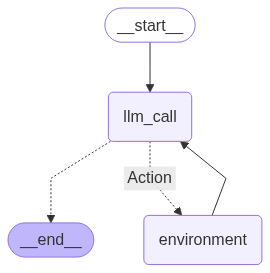

In [29]:
from typing_extensions import Literal
from langchain_core.messages import ToolMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, MessagesState, START, END
from IPython.display import Image, display

# Bind the tools to the model
model_with_tools = model.bind_tools(tools)
tools_by_name = {tool.name: tool for tool in tools}

# Nodes
async def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            await model_with_tools.ainvoke(
                [
                    {"role": "system", "content": system_prompt}
                ]
                + state["messages"]
            )
        ]
    }
    
async def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = await tool.ainvoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
async def should_continue(state: MessagesState) -> Literal["environment", "__end__"]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Test with async invocation
result = await agent.ainvoke({
    "messages": [{"role": "system", "content": system_prompt}, {"role": "user", "content": research_prompt}]
})

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 📝 System ───────────────────────────────────────────────────╮
│ You are a research assistant with access to local file system tools through MCP (Model Context Protocol). Your  │
│ role is to help users conduct thorough research by systematically accessing and analyzing local documents.      │
│                                                                                                                 │
│ CRITICAL SECURITY STEP:                                                                                         │
│ 🔒 ALWAYS start by calling list_allowed_directories to check what directories you can access. This is a         │
│ security requirement that prevents access errors.                                                               │
│                                                                                                                 │
│ AVAILABLE TOOLS:                                                                                                │
│ You have access to filesystem tools that can:                                                                   │
│ - list_allowed_directories: Returns directories you can access (CALL THIS FIRST!)                               │
│ - list_directory: List files and directories in the research documents folder                                   │
│ - read_file: Read the complete contents of specific files                                                       │
│ - read_multiple_files: Read multiple files simultaneously (more efficient)                                      │
│ - search_files: Search for files containing specific content                                                    │
│ - get_file_info: Get metadata about files (size, modification date, etc.)                                       │
│                                                                                                                 │
│ SECURE RESEARCH METHODOLOGY:                                                                                    │
│ 1. **FIRST - Check permissions**: Use list_allowed_directories to see what you can access                       │
│ 2. **Then explore**: Use list_directory to see available files in allowed directories                           │
│ 3. **Read strategically**: Only read files that are relevant to the user's request                              │
│ 4. **Read each file ONCE**: Don't repeatedly read the same file - remember the content                          │
│ 5. **Use efficient tools**: Use read_multiple_files when you need multiple files                                │
│ 6. **Be targeted**: Focus on files that match the user's specific needs                                         │
│                                                                                                                 │
│ AVAILABLE FILES (typically):                                                                                    │
│ Based on the expected directory structure, you should find:                                                     │
│ - coffee_shops_sf.md: Contains information about San Francisco coffee shops                                     │
│ - reasoning.md: Contains reasoning or methodology content                                                       │
│                                                                                                                 │
│ RESPONSE OPTIMIZATION:                                                                                          │
│ - ALWAYS start with list_allowed_directories                                                                    │
│ - Then use list_directory to confirm available files                                                            │
│ - Clearly identify which files are relevant to the user's request                                               │
│ - Read only the necessary files for the specific questio

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I need comprehensive information about coffee shops in San Francisco.                                           │
│                                                                                                                 │
│  **Provide a comprehensive summary**: Based on the files you've read, give me a detailed overview of:           │
│    - Popular coffee shops and their specialties                                                                 │
│    - Local coffee culture and trends                                                                            │
│    - Best neighborhoods for coffee enthusiasts                                                                  │
│    - Unique or notable coffee experiences in SF                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get comprehensive information about coffee shops in San Francisco. Let me start by checking what  │
│ directories I can access and then locate the relevant files.                                                    │
│                                                                                                                 │
│ 🔧 Tool Call: list_allowed_directories                                                                          │
│    Args: {}                                                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: list_allowed_directories                                                                          │
│    Args: {}                                                                                                     │
│    ID: toolu_01QoTMuntLUCHMaPVPyNyUes                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Allowed directories:                                                                                            │
│ /Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files"                                  │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: list_directory                                                                                    │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files"                                  │
│ }                                                                                                               │
│    ID: toolu_0113bEARWxvaccttLdjT9gwA                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ [FILE] coffee_shops_sf.md                                                                                       │
│ [FILE] reasoning.md                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! I can see there's a `coffee_shops_sf.md` file that should contain exactly what you're looking for. Let │
│ me read it to provide you with comprehensive information about San Francisco coffee shops.                      │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files/coffee_shops_sf.md"               │
│ }                                                                                                               │
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "path": "/Users/rlm/Desktop/Code/deep_research_from_scratch/notebooks/files/coffee_shops_sf.md"               │
│ }                                                                                                               │
│    ID: toolu_019Kg4saKRxFpoAW2qXwzvAD                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # San Francisco Coffee Shops Research                                                                           │
│                                                                                                                 │
│ ## Top Coffee Shops in San Francisco                                                                            │
│                                                                                                                 │
│ ### Blue Bottle Coffee                                                                                          │
│ - **Founded**: 2002 in Oakland, expanded to SF                                                                  │
│ - **Specialty**: Single-origin coffee, pour-over methods                                                        │
│ - **Notable**: Known for freshly roasted beans, minimalist aesthetic                                            │
│ - **Locations**: Multiple SF locations including Ferry Building                                                 │
│                                                                                                                 │
│ ### Philz Coffee                                                                                                │
│ - **Founded**: 2003 in San Francisco                                                                            │
│ - **Specialty**: Custom blended coffee, personalized service                                                    │
│ - **Notable**: Founded by Phil Jaber, known for unique blends like "Tesora"                                     │
│ - **Locations**: Original location in Mission District, now citywide                                            │
│                                                                                                                 │
│ ### Sightglass Coffee                                                                                           │
│ - **Founded**: 2009                                                                                             │
│ - **Specialty**: Third-wave coffee, roasting transparency                                                       │
│ - **Notable**: Large roastery with viewing windows, industrial aesthetic                                        │
│ - **Location**: SOMA district flagship location                                                                 │
│                                                                                                                 │
│ ### Ritual Coffee Roasters                                                                                      │
│ - **Founded**: 2005                                                                                             │
│ - **Specialty**: Direct trade relationships, seasonal offerings                                                 │
│ - **Notable**: Pioneer in San Francisco's third-wave coffee movement                                            │
│ - **Locations**: Multiple locations including Castro and Mission                                                │
│                                                                                                                 │
│ ### Four Barrel Coffee                                                                                          │
│ - **Founded**: 2008                                                                                             │
│ - **Specialty**: Small-batch roasting, community focus                                                          │
│ - **Notable**: Known for Valencia Street location, local institution                                            │
│ - **Location**: Mission District                                                                                │
╰────────────────────────────────────────────────────────

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on the research file, here's a comprehensive overview of San Francisco's coffee scene:                    │
│                                                                                                                 │
│ ## **Popular Coffee Shops and Their Specialties**                                                               │
│                                                                                                                 │
│ ### **Blue Bottle Coffee**                                                                                      │
│ - **Founded**: 2002 (Oakland origins, expanded to SF)                                                           │
│ - **Specialty**: Single-origin coffee and pour-over methods                                                     │
│ - **Notable Features**: Freshly roasted beans, minimalist aesthetic                                             │
│ - **Key Location**: Ferry Building plus multiple SF locations                                                   │
│                                                                                                                 │
│ ### **Philz Coffee**                                                                                            │
│ - **Founded**: 2003 in San Francisco                                                                            │
│ - **Specialty**: Custom blended coffee with personalized service                                                │
│ - **Notable Features**: Founded by Phil Jaber, famous for unique blends like "Tesora"                           │
│ - **Origin**: Mission District (now citywide)                                                                   │
│                                                                                                                 │
│ ### **Sightglass Coffee**                                                                                       │
│ - **Founded**: 2009                                                                                             │
│ - **Specialty**: Third-wave coffee with roasting transparency                                                   │
│ - **Notable Features**: Large roastery with viewing windows, industrial aesthetic                               │
│ - **Key Location**: SOMA district flagship                                                                      │
│                                                                                                                 │
│ ### **Ritual Coffee Roasters**                                                                                  │
│ - **Founded**: 2005                                                                                             │
│ - **Specialty**: Direct trade relationships and seasonal offerings                                              │
│ - **Notable Features**: Pioneer in San Francisco's third-wave coffee movement                                   │
│ - **Locations**: Castro and Mission districts                                                                   │
│                                                                                                                 │
│ ### **Four Barrel Coffee**                                                                                      │
│ - **Founded**: 2008                                                                                             │
│ - **Specialty**: Small-batch roasting with community focus                                                      │
│ - **Notable Features**: Valencia Street location, established local institution                                 │
│ - **Key Location**: Mission District                                                                            │
│                                                        